In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, os
import pandas as pd, numpy as np, seaborn as sn, imp
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
sn.set_context('notebook')

# ECCO-DomQua data processing

In a [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/spatial_interpolation/blob/master/spatial_interpolation_2.ipynb) I developed and tested code for spatially interpolating the ECCO-DomQua data over Fenoscandia. The key classes and functions used in that notebook have been moved into a new file called [`spatial_interpolation.py`](https://github.com/JamesSample/spatial_interpolation/blob/master/spatial_interpolation.py), which means I can now import and use them in other notebooks without have to re-enter all the code. This should help to keep subsequent notebooks tidy.

In this notebook, I'm going to use my spatial interpolation code to generate the grids required for the ECCO-DomQua project. The main datasets are described here:

K:\Prosjekter\Klima\O-13382 DomQua HWI\8 Future DOC\Gridded_Data_Tasks.docx

Leah would like gridded versions of the EMEP data for 1995, 2010, 2020 and 2030. She would also like 1995 water chemistry grids for TOC, Cl, nmCaMg, SO4 and nmSO4.

## 1. Import functions

The functions and classes created in the [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/spatial_interpolation/blob/master/spatial_interpolation_2.ipynb) are imported below.

In [2]:
# Import custom functions
spat_int_path = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Python'
                 r'\spatial_interpolation\spatial_interpolation.py')

spat_int = imp.load_source('spatial_interpolation', spat_int_path)

## 2. Read raw data

### 2.1. EMEP

In [3]:
# Read EMEP
emep_xlsx = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\S_LoLa_a_tidy.xlsx')
emep_df = pd.read_excel(emep_xlsx, sheetname='Sheet1')

emep_df.head()

,Lon,Lat,1880,1885,1890,1895,1900,1905,1910,1915,...,1975,1980,1985,1990,1995,2000,2005,2010,2020,2030
0,7.5,54.0,557.0,630.3,735.3,791.5,960.1,1044.2,1217.7,1264.0,...,3469.8,3554.3,2832.7,2353.4,1172.4,767.1,629.3,481.1,237.9,200.9
1,8.5,54.0,537.2,619.0,729.4,791.2,973.0,1068.6,1263.2,1313.2,...,3960.8,4115.2,3179.9,2664.0,1226.6,791.2,643.4,492.8,261.4,220.4
2,9.0,54.0,504.2,586.3,695.6,761.0,943.1,1044.2,1242.0,1304.7,...,4264.2,4437.3,3443.9,3056.1,1271.8,805.6,654.7,510.8,284.8,241.9
3,9.5,54.0,482.0,566.0,676.7,746.7,932.7,1040.8,1245.7,1320.6,...,4612.2,4806.9,3868.9,3905.3,1426.0,884.0,720.0,581.6,344.9,293.0
4,10.0,54.0,482.0,567.8,680.8,753.4,943.5,1055.4,1266.2,1345.3,...,4802.9,5013.2,4366.7,3186.4,1191.0,736.0,600.0,486.4,287.2,245.6


### 2.2. Water chemistry

In [4]:
# Read chemistry
chem_xlsx = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Water_Chem\Nordic_data_GIS_Import.xlsx')
chem_df = pd.read_excel(chem_xlsx, sheetname='Nordic95_LakeChem_SiteProprties')

chem_df.head()

,Station_ID,Lat,Long,Country,TOC,Cl,nmCaMg,SO4,nmSO4
0,9,59.00,11.56,Norway,10.0,174.87,66.76,99.93,81.92
1,10,59.80,11.85,Norway,11.7,53.59,81.82,62.45,56.94
2,11,60.05,12.44,Norway,12.1,42.30,105.92,62.45,58.10
3,12,60.32,11.84,Norway,8.0,28.20,43.08,56.21,53.30
4,13,60.59,12.51,Norway,9.3,22.56,83.41,54.13,51.80


## 3. Map projection

Set the map projection and define the grid for interpolation.

In [5]:
# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=2000000,
            height=2000000,
            resolution='i',
            lat_1=53,          # 1st standard parallel
            lat_2=73,          # 2st standard parallel
            lon_0=15,lat_0=63, # Central point
            ellps='WGS84')     # http://matplotlib.org/basemap/api/basemap_api.html

# Set up 25 km grid for interpolation
# Shift by (cell_size/2) s.t. values are estimated for the centre of each grid square
cell_size = 25000 # metres
gridx = np.arange(int(m.xmin), int(m.xmax), cell_size) + (cell_size/2.)
gridy = np.arange(int(m.ymin), int(m.ymax), cell_size) + (cell_size/2.)

## 4. Interpolation

### 4.1. EMEP

Perform interpolation of the EMEP data using both IDW (with `n_near=8` and `p=2`) and cubic spline algorithms.

In [6]:
# Output folder
out_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\Output_GTiffs'

# Map (long, lat) to projected (x, y)
x, y = m(emep_df['Lon'].values, emep_df['Lat'].values)

# Reformat to synatx required by interp algorithms
pts = np.array(zip(x ,y))

# Loop over years
for year in [1995, 2010, 2020, 2030]:    
    # Get values to interpolate
    vals = emep_df[year].values

    # IDW interpolation
    idw = spat_int.idw_interp(pts, vals, 
                              gridx, gridy, 
                              n_near=8, p=2)

    # Spline interpolation
    xx, yy = np.meshgrid(gridx, gridy) 
    spl = griddata(pts, vals, 
                   (xx, yy), 
                   method='cubic')

    # Save output
    # IDW
    idw_path = os.path.join(out_fold, 'emep_%s_idw_n8_p2.tif' % year)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            idw_path, idw, m.proj4string)
    
    # Spline
    spl_path = os.path.join(out_fold, 'emep_%s_spline.tif' % year)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            spl_path, spl, m.proj4string)

### 4.2. Water chemistry

Perform interpolation of the water chemistry data using both IDW (with `n_near=8` and `p=2`) and cubic spline algorithms.

In [7]:
# Output folder
out_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Water_Chem\Output_GTiffs'

# Map (long, lat) to projected (x, y)
x, y = m(chem_df['Long'].values, chem_df['Lat'].values)

# Reformat to synatx required by interp algorithms
pts = np.array(zip(x ,y))

# Loop over years
for par in ['TOC', 'Cl', 'nmCaMg', 'SO4', 'nmSO4']:    
    # Get values to interpolate
    vals = chem_df[par].values

    # IDW interpolation
    idw = spat_int.idw_interp(pts, vals, 
                              gridx, gridy, 
                              n_near=8, p=2)

    # Spline interpolation
    xx, yy = np.meshgrid(gridx, gridy) 
    spl = griddata(pts, vals, 
                   (xx, yy), 
                   method='cubic')

    # Save output
    # IDW
    idw_path = os.path.join(out_fold, 'chem_%s_idw_n8_p2.tif' % par)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            idw_path, idw, m.proj4string)
    
    # Spline
    spl_path = os.path.join(out_fold, 'chem_%s_spline.tif' % par)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            spl_path, spl, m.proj4string)

## 5. Visualisation

### 5.1. EMEP

The plots below show the EMEP output (note that each plot uses its own scale).

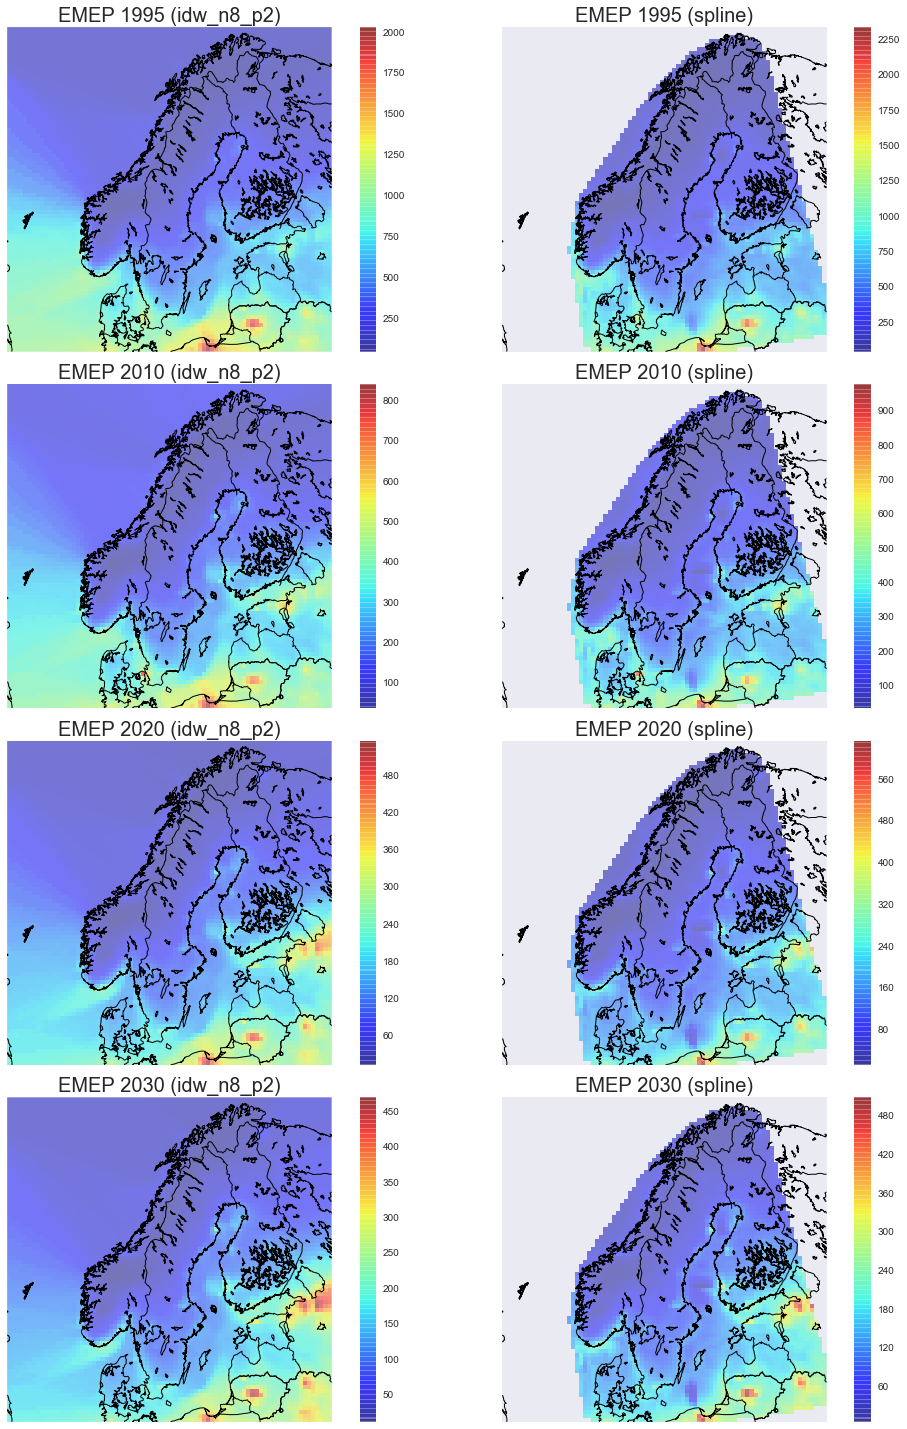

In [8]:
# Data folder
data_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\Output_GTiffs'

fig = plt.figure(figsize=(15, 20))
cnt = 0

for year in [1995, 2010, 2020, 2030]:
    for meth in ['idw_n8_p2', 'spline']:
        cnt += 1
        
        # Read data
        gtiff_path = os.path.join(data_fold, 'emep_%s_%s.tif' % (year, meth))
        data = spat_int.read_geotiff(gtiff_path)[0]
        
        # Plot
        ax = fig.add_subplot(4, 2, cnt)
        ax.set_title('EMEP %s (%s)' % (year, meth), fontsize=20)
        cax = m.imshow(data, 
                       cmap='jet', alpha=0.5, 
                       interpolation='none')
        m.drawcoastlines(linewidth=1)
        m.drawcountries(linewidth=1)
        cbar = fig.colorbar(cax)

plt.tight_layout()

For ease of comparison, we can force all the plots to use the same colour scheme by using the `vmin` and `vmax` arguments (although the deposition for more recent years is so low compared to 1995 that variations become difficult to distinguish).

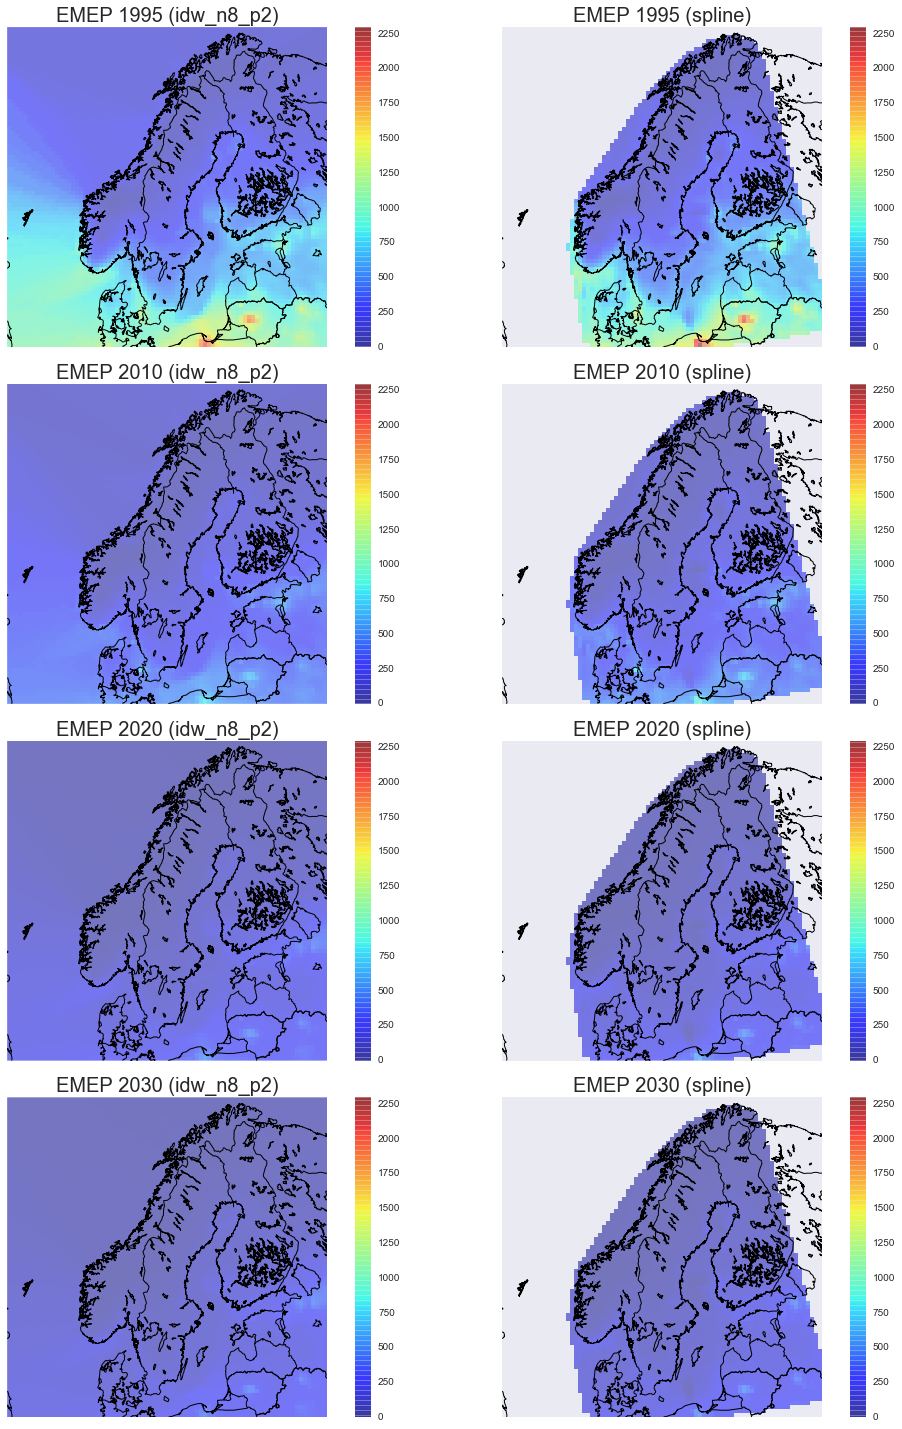

In [9]:
# Data folder
data_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\EMEP_Data\Output_GTiffs'

fig = plt.figure(figsize=(15, 20))
cnt = 0

for year in [1995, 2010, 2020, 2030]:
    for meth in ['idw_n8_p2', 'spline']:
        cnt += 1
        
        # Read data
        gtiff_path = os.path.join(data_fold, 'emep_%s_%s.tif' % (year, meth))
        data = spat_int.read_geotiff(gtiff_path)[0]
        
        # Plot
        ax = fig.add_subplot(4, 2, cnt)
        ax.set_title('EMEP %s (%s)' % (year, meth), fontsize=20)
        cax = m.imshow(data, 
                       cmap='jet', alpha=0.5, 
                       interpolation='none',
                       vmin=0, vmax=2300)
        m.drawcoastlines(linewidth=1)
        m.drawcountries(linewidth=1)
        cbar = fig.colorbar(cax)

plt.tight_layout()

### 5.2. Water chemistry

Similarly, the code below generates plots for water chemistry.

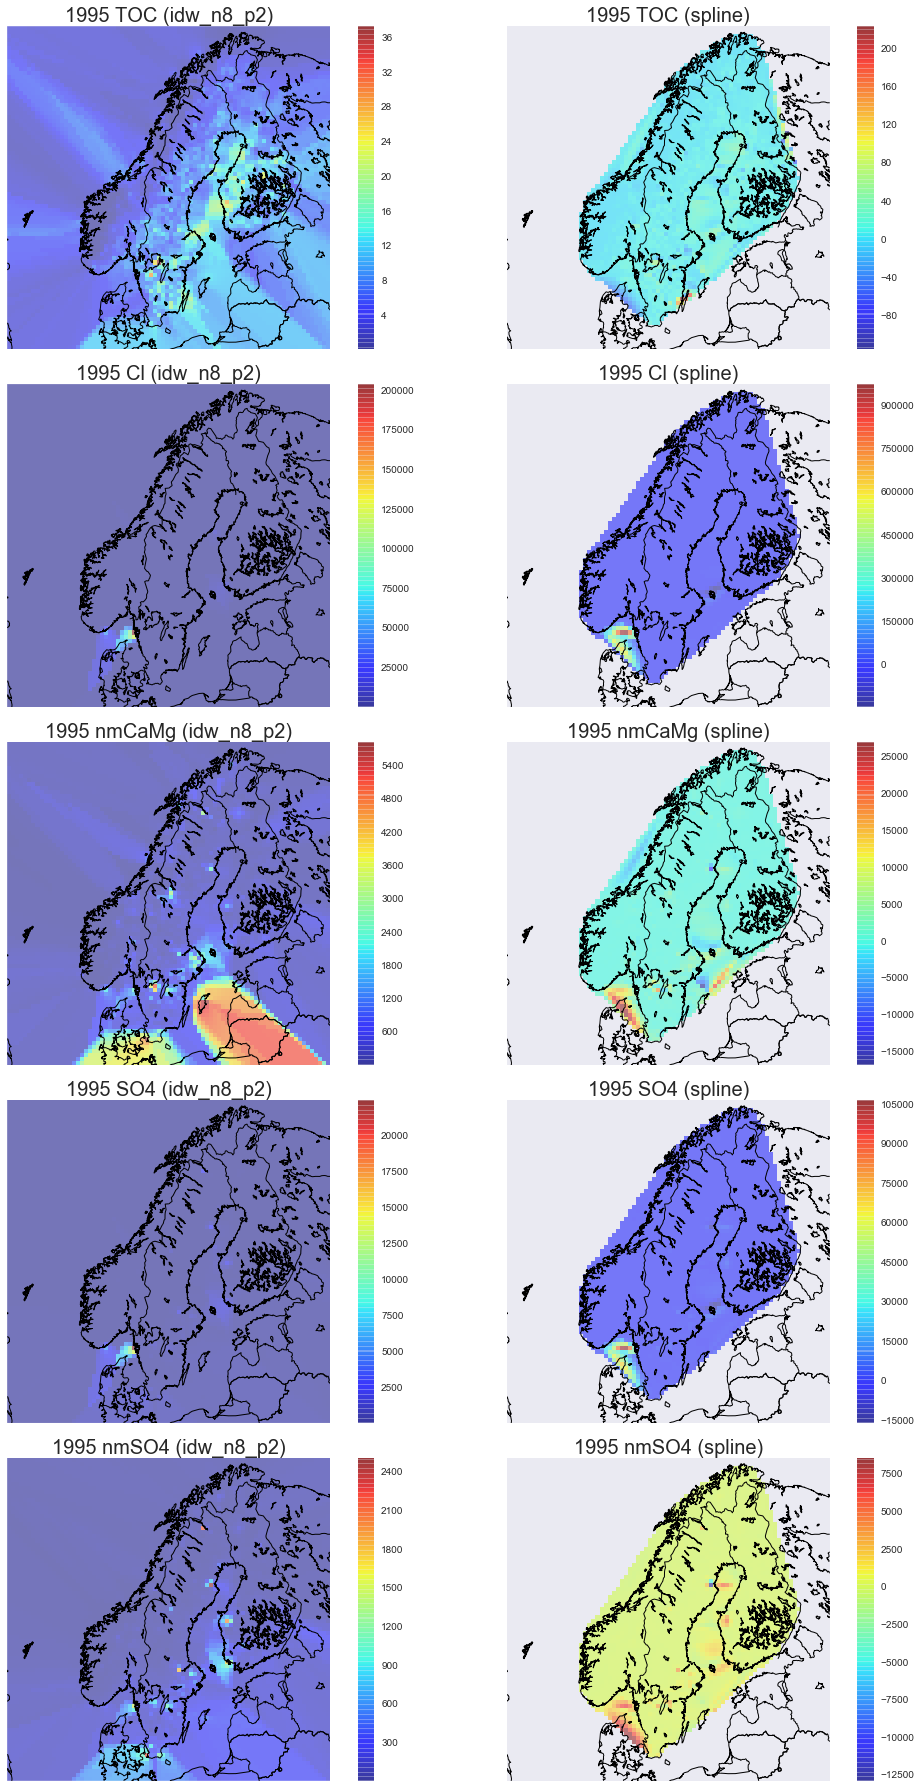

In [10]:
# Data folder
data_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Water_Chem\Output_GTiffs'

fig = plt.figure(figsize=(15, 25))
cnt = 0

for par in ['TOC', 'Cl', 'nmCaMg', 'SO4', 'nmSO4']:
    for meth in ['idw_n8_p2', 'spline']:
        cnt += 1
        
        # Read data
        gtiff_path = os.path.join(data_fold, 'chem_%s_%s.tif' % (par, meth))
        data = spat_int.read_geotiff(gtiff_path)[0]
        
        # Plot
        ax = fig.add_subplot(5, 2, cnt)
        ax.set_title('1995 %s (%s)' % (par, meth), fontsize=20)
        cax = m.imshow(data, 
                       cmap='jet', alpha=0.5, 
                       interpolation='none')
        m.drawcoastlines(linewidth=1)
        m.drawcountries(linewidth=1)
        cbar = fig.colorbar(cax)

plt.tight_layout()

The water chemistry data is clearly more difficult to interpolate. In particular, the output from the splines algorithm seems rather extreme, and often involves large negative values. This is due to outliers in the raw data forcing very tight bends in the spline surface, resulting in large 'spikes' and 'dips' that sometimes become negative. Overall, I'd be inclined to use the IDW output rather than the splines results here, as the values for IDW are always calculated as an average of the actual measurements, reducing some of the weird effects associated with the "rubber-sheeting" behaviour of the splines algorithm. Having said that, I also think it would be worth **checking the raw data carefully for outliers**, or perhaps log-transforming the data prior to interpolation? Something to investigate.

## 6. Masking

Depending on the exact area of interest, I could produce a mask grid to set e.g. marine areas in the interpolated output to `NoData`. Would this be useful? Are we only interested in interpolated values over the land, or do we care about e.g. the Baltic Sea as well? **Check with Leah**.

## 7. Experimenting

Out of interest, what do the water chemistry results look like when interpolated using many more neighbours (e.g. `n_near=100`) and `p=1`?

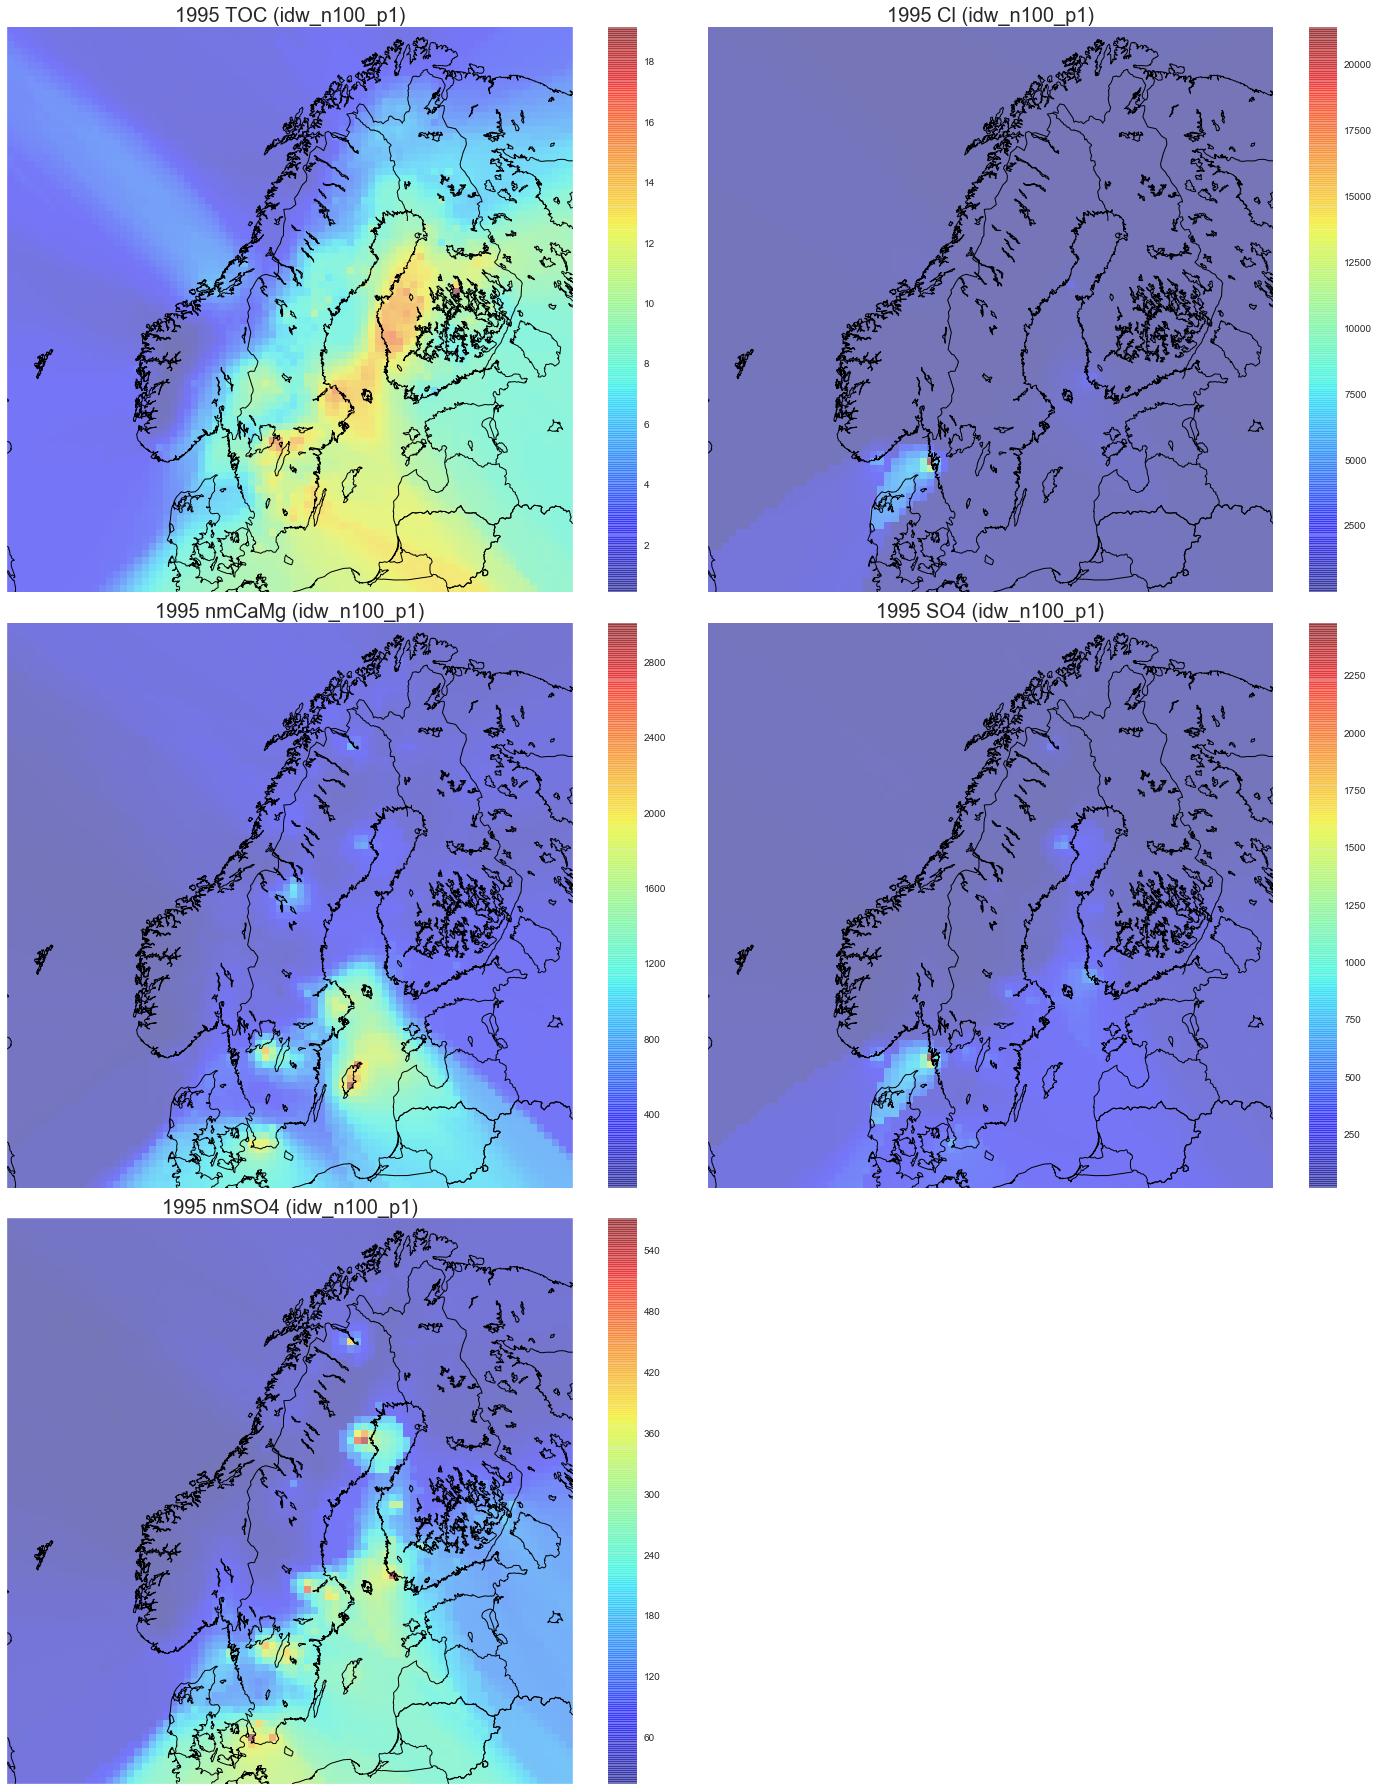

In [11]:
# Output folder
out_fold = r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Water_Chem\Output_GTiffs'

# Map (long, lat) to projected (x, y)
x, y = m(chem_df['Long'].values, chem_df['Lat'].values)

# Reformat to synatx required by interp algorithms
pts = np.array(zip(x ,y))

# Loop over years
for par in ['TOC', 'Cl', 'nmCaMg', 'SO4', 'nmSO4']:    
    # Get values to interpolate
    vals = chem_df[par].values

    # IDW interpolation
    idw = spat_int.idw_interp(pts, vals, 
                              gridx, gridy, 
                              n_near=100, p=1)

    # Save output
    # IDW
    idw_path = os.path.join(out_fold, 'chem_%s_idw_n100_p1.tif' % par)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            idw_path, idw, m.proj4string)
    
# Plot
fig = plt.figure(figsize=(20, 25))

for idx, par in enumerate(['TOC', 'Cl', 'nmCaMg', 'SO4', 'nmSO4']):
    # Read data
    gtiff_path = os.path.join(data_fold, 'chem_%s_idw_n100_p1.tif' % par)
    data = spat_int.read_geotiff(gtiff_path)[0]

    # Plot
    ax = fig.add_subplot(3, 2, idx+1)
    ax.set_title('1995 %s (idw_n100_p1)' % par, fontsize=20)
    cax = m.imshow(data, 
                   cmap='jet', alpha=0.5, 
                   interpolation='none')
    m.drawcoastlines(linewidth=1)
    m.drawcountries(linewidth=1)
    cbar = fig.colorbar(cax)

plt.tight_layout()

These results are perhaps a bit more reasonable? **Something to investigate further...**